

# Experiments on Images


## Loading libraries

In [ ]:
from fastai import *
from fastai.vision.all import *
import umap
from torchvision import transforms
import numpy as np
import torch
from torch import nn

from thesis.modules_th.video_block import *
from thesis.modules_th.triplet_loss import *
from thesis.modules_th.supcon_module import *
from thesis.modules_th.cus_cbs import *


In [ ]:
path_to_save_experiments = Path('experiments_on_images')



## Supervised Contrastive Model 

In [ ]:
#Data from path
embs_size = 128
bs = 16 

# items data
df = pd.read_csv('experiments_on_images/train_CALTECH101.csv')
items = df.img_files.values

#Tfms pipelines
img_pip = [PILImage.create, Resize(512)]
lbl_pip = [parent_label, Categorize()]
pip = [img_pip, img_pip, lbl_pip]
tfms = aug_transforms(size=128)

#splits
splits = ColSplitter('val')(df)

# Datasets and dataloaders
dsets = Datasets(items, pip, splits=splits)
dls = dsets.dataloaders(bs=bs,shuffle_train=True, after_item=ToTensor(), after_batch = tfms +[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)] )

In [ ]:
# set up leaner training
n_views = len(pip)-1
p = 'cos'

# Model setup
encoder, head = create_body(resnet50, cut=-2), create_head(4096, embs_size)
model = ContrastiveModel(encoder,head)

#Loss
loss = SupConLoss(p=p)

#Learner
learn = Learner(dls,
                model,
                splitter= enc_head_splitter,
                loss_func=loss,
               metrics = silh_score)
learn.add_cbs([ContrastiveCallback(n_views)])

In [ ]:
sched = {'lr': combine_scheds([0.1,0.9], [SchedLin(0.0001,0.001), SchedCos(0.001, 0.0001)])}
custom_sched = ParamScheduler(sched)
Logs_csv =   CSVLogger(fname='logs_SCL5_.csv', append=False) 


learn.fine_tune(100, cbs= [Logs_csv])


epoch,train_loss,valid_loss,silh_score,time
0,1.067359,0.821195,0.869196,00:47


epoch,train_loss,valid_loss,silh_score,time
0,0.722105,0.685096,0.884651,00:45
1,0.740528,0.682089,0.890170,01:08
2,0.812853,0.651993,0.894402,00:45
3,0.699304,0.616695,0.897001,01:45
4,0.736287,0.613098,0.898512,00:45
5,0.700297,0.602947,0.904205,01:45
6,0.685771,0.604461,0.906056,00:47
7,0.652063,0.592660,0.908685,00:48
8,0.707812,0.563402,0.913335,00:47
9,0.694868,0.564389,0.913720,00:48


In [ ]:
learn.export('SCL_bs16')

In [ ]:
learn.load('SCL')

In [ ]:
learn.validate()

(#2) [0.4951684772968292,0.9417153065288631]

In [ ]:
# Test 
df = pd.read_csv('experiments_on_images/test_CALTECH101.csv')
item = df.img_files.values

test_dl = learn.dls.test_dl(item, with_labels=True) 
preds, lbls = learn.get_preds(dl= test_dl)



In [ ]:
# Umap Embs
cmap='tab10'
reducer = umap.UMAP()

fv = preds.unbind(dim=1)[0]

print(fv.shape)
print(lbls.shape)

UMAPembeddings=reducer.fit_transform(fv)

from sklearn.metrics import silhouette_score
print(silhouette_score(fv,lbls))

torch.Size([914, 128])
(914,)
0.5602354


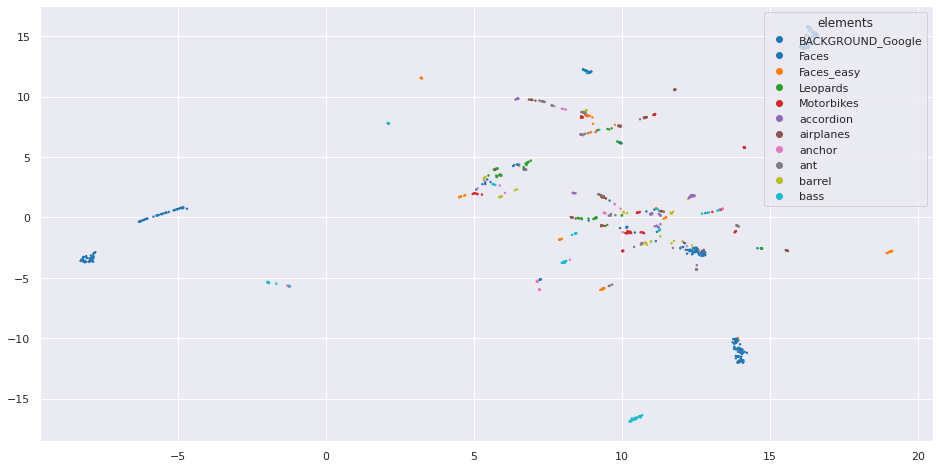

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))

scatter=ax.scatter(x=UMAPembeddings[:,0],y=UMAPembeddings[:,1], s=2, c=np.array(lbls),cmap=cmap)
#scatter=ax.scatter(x=fv[:,0],y=fv[:,1], s=2, c=np.array(lbls),cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0],labels=dls.vocab,
                    loc="upper right", title="elements")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(fv,lbls)


0.5602354

## Triplet Loss

In [ ]:
df.head()

,img_files,lbls,val
0,/home/eugenio/.fastai/data/caltech_101/Faces_easy/image_0435.jpg,Faces_easy,False
1,/home/eugenio/.fastai/data/caltech_101/airplanes/image_0524.jpg,airplanes,False
2,/home/eugenio/.fastai/data/caltech_101/trilobite/image_0060.jpg,trilobite,False
3,/home/eugenio/.fastai/data/caltech_101/trilobite/image_0049.jpg,trilobite,False
4,/home/eugenio/.fastai/data/caltech_101/airplanes/image_0086.jpg,airplanes,False


In [ ]:

#Data from path
embs_size = 128
n_el,n_lbl = 8,8

# items data
df = pd.read_csv('experiments_on_images/train_CALTECH101.csv')
items = df.img_files.values
lbls = df.lbls.values

#Tfms pipelines
img_pip = [PILImage.create, Resize(512)]
lbl_pip = [parent_label, Categorize()]
pip = [img_pip, img_pip, lbl_pip]
tfms = aug_transforms(size=128)

#splits
splits = ColSplitter('val')(df)

# Datasets and dataloaders
dsets = Datasets(items, pip, splits=splits)
dls = dsets.dataloaders(bs=n_el*n_lbl,shuffle_train=True, 
                        after_item=ToTensor(), 
                        after_batch = tfms +[IntToFloatTensor(),
                                                                    Normalize.from_stats(*imagenet_stats)],
                        shuffle_fn=UniformizedShuffle(lbls[splits[0]], n_el=n_el,n_lbl=n_lbl)
                       )

In [ ]:
lbls[splits[0]]

array(['Faces_easy', 'airplanes', 'trilobite', ..., 'camera', 'watch',
       'yin_yang'], dtype=object)

In [ ]:
encoder, head = create_body(resnet50, cut=-2), create_head(4096, 128)
model = ContrastiveModel(encoder,head)
learn=Learner(dls,
            model,
            loss_func=TripletLoss(p=2, margin= 0.5),
             metrics=silh_score)

In [ ]:

learn.fine_tune(100,cbs=CSVLogger('logs_TL1_100.csv'))

TypeError: list indices must be integers or slices, not list

In [ ]:
?? uniformize_dataset

Signature:  uniformize_dataset(items, lbls, vocab=None, n_el=3, n_lbl=3, shuffle=True)
Docstring: <no docstring>
Source:   
def uniformize_dataset(items, lbls, vocab=None, n_el=3, n_lbl=3, shuffle=True):
    if vocab is None: vocab = list(set(lbls))
    lbl2idxs = {lbl:[] for lbl in vocab}
    for i, lbl in enumerate(lbls): lbl2idxs[lbl].append(i)
    for lbl, idxs in lbl2idxs.items():
        if len(idxs) < n_el: vocab.remove(lbl)
    if shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
    idxs = []
    while len(vocab) >= n_lbl:
        lbl_samples = random.sample(vocab, n_lbl)
        for lbl in lbl_samples:
            i = 0
            while i < n_el:
                i += 1
                idx = lbl2idxs[lbl].pop()
                idxs.append(idx)
            if len(lbl2idxs[lbl]) <= n_el:
                vocab.remove(lbl)
    return getattr(items, 'iloc', items)[idxs]
File:      /mnt/data/eugeniomarinelli/thesis/modules_th/video_block.py
Type:      function


In [ ]:
learn.save('onlyTL')


Path('models/onlyTL_03.pth')

In [ ]:
learn=learn.load('onlyTL_01')

RuntimeError: Error(s) in loading state_dict for ContrastiveModel:
	size mismatch for head.8.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([128, 512]).

In [ ]:
learn.validate()

## CNN model with Cross Entropy Loss

In [ ]:
#Data from csv

df = pd.read_csv('experiments_on_images/train_CALTECH101.csv')
items = df.img_files.values
bs = 64
tfms = aug_transforms(size=128)
img_pip = [PILImage.create, Resize(300)]
lbl_pip = [parent_label, Categorize()]
pip = [img_pip, lbl_pip]
splits = ColSplitter('val')(df)
dsets = Datasets(items, pip, splits=splits)

dls = dsets.dataloaders(bs=bs,shuffle_train=True, after_item=ToTensor(), after_batch = tfms +[IntToFloatTensor(),Normalize.from_stats(*imagenet_stats)] )

In [ ]:
class CEL(Module):
    def forward(self, out, y):
        CEL = CrossEntropyLossFlat()(out[0], y)
        return CEL 

In [ ]:

head, body = create_head(4096, len(dls.vocab), lin_ftrs=[128]), create_body(resnet50, cut=-2)
model = AnomalyDetectionModel(body, head)
sched = {'lr': combine_scheds([0.25,0.75], [SchedLin(0.0001,0.001), SchedCos(0.001, 0.0001)])}
learn=Learner(dls,
            model,
            splitter= enc_head_splitter,
            loss_func= CEL(), 
             metrics = [tl_accuracy,silh_score])
#learn.add_cbs([MultiViewsCallback(dls.n_inp)])

In [ ]:
sched = {'lr': combine_scheds([0.1,0.9], [SchedLin(0.0001,0.001), SchedCos(0.001, 0.0001)])}
Logs_csv =   CSVLogger(fname='logs_CEL4_100.csv', append=False) 


learn.fine_tune(100, cbs= [ParamScheduler(sched),Logs_csv])

epoch,train_loss,valid_loss,tl_accuracy,silh_score,time
0,1.936181,1.320621,0.793439,0.142139,00:12


epoch,train_loss,valid_loss,tl_accuracy,silh_score,time
0,1.117863,0.669311,0.893074,0.277298,00:16
1,0.769991,0.578239,0.873633,0.285710,00:16
2,0.656339,0.632661,0.860267,0.234509,00:16
3,0.707174,0.718133,0.820170,0.247408,00:16
4,0.773379,0.969321,0.738761,0.179072,00:16
5,0.778506,0.897072,0.793439,0.213793,00:16
6,0.774807,0.829281,0.783718,0.194353,00:16
7,0.751870,0.948388,0.775213,0.178817,00:16
8,0.795550,1.014502,0.736331,0.181932,00:16
9,0.820713,1.050454,0.736331,0.162059,00:16


In [ ]:
learn.loss_func

CEL()

In [ ]:
learn.save('CEL_sched_100')

Path('models/CEL_sched_100.pth')

In [ ]:
learn.lr_find()

In [ ]:
learn.load('CEL_sched_100')
learn.validate()

(#3) [0.48408329486846924,0.8942891955375671,0.2276081291467567]

In [ ]:
# Test 
df = pd.read_csv('experiments_on_images/test_CALTECH101.csv')
item = df.img_files.values

test_dl = learn.dls.test_dl(item, with_labels=True) 
preds, lbls = learn.get_preds(dl= test_dl)

In [ ]:
learn

In [ ]:
# Umap Embs
cmap='tab10'
reducer = umap.UMAP()


fv = preds[1]
UMAPembeddings=reducer.fit_transform(fv)

print(fv.shape)
print(lbls.shape)

torch.Size([914, 128])
(914,)


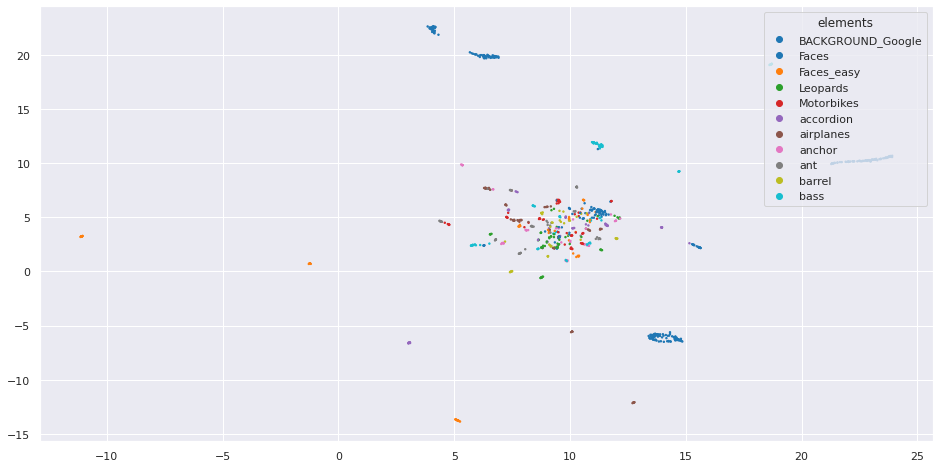

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(16,8))

scatter=ax.scatter(x=UMAPembeddings[:,0],y=UMAPembeddings[:,1], s=2, c=np.array(lbls),cmap=cmap)
#scatter=ax.scatter(x=fv[:,0],y=fv[:,1], s=2, c=np.array(lbls),cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0],labels=dls.vocab,
                    loc="upper right", title="elements")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(fv,lbls)

0.40309677

In [ ]:
accuracy(preds[0],lbls)

TensorCategory(0.9015)

# Building csv


In [ ]:
import pandas as pd

path = untar_data(URLs.CALTECH_101)
items = get_image_files(path)
lbls= L(map(parent_label,items))

tr_va,test = RandomSplitter(valid_pct=0.1)(items)

train,val = RandomSplitter(valid_pct=0.1)(items[tr_va])
is_val = L(False)*len(tr_va)
is_val[val] = True
df = pd.DataFrame(list(zip(items[tr_va],lbls[tr_va],is_val)), columns=['img_files','lbls','val'])
df_test = pd.DataFrame(list(zip(items[test],lbls[test])), columns=['img_files','lbls'])
df_test.head()

,img_files,lbls
0,/home/eugenio/.fastai/data/caltech_101/hawksbill/image_0033.jpg,hawksbill
1,/home/eugenio/.fastai/data/caltech_101/brain/image_0092.jpg,brain
2,/home/eugenio/.fastai/data/caltech_101/lotus/image_0031.jpg,lotus
3,/home/eugenio/.fastai/data/caltech_101/BACKGROUND_Google/image_0049.jpg,BACKGROUND_Google
4,/home/eugenio/.fastai/data/caltech_101/dolphin/image_0051.jpg,dolphin


In [ ]:
df.to_csv(path_to_save_experiments/'train_CALTECH101.csv', index=False)
df_test.to_csv(path_to_save_experiments/'test_CALTECH101.csv',index = False)

In [ ]:
items

(#9144) [Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0008.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0002.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0015.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0031.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0025.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0006.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0017.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0026.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0032.jpg'),Path('/home/eugenio/.fastai/data/caltech_101/wild_cat/image_0034.jpg')...]

## Prove


In [ ]:
class Cprova(Module):
    def __init__(self, n_lbl, p=2, margin=0.2, cpu=False):
        self.tripletLoss = nn.TripletMarginLoss(margin=margin, p=p)
        self.cpu = cpu
        self.p = p
        self.n_lbl = n_lbl
    def forward(self, embs, y):
 #       embs = embs.to('cpu') if  self.cpu() else embs
        d = -embs@embs.T if self.p=='cos' else torch.cdist(embs,embs,self.p)
        N = len(embs)
        with torch.no_grad():            
            # Getting indexes of the Positive and Negative sample of each Anchor
            dp, dn = d.clone(), d.clone() 

In [ ]:
# Prova della Triplet Loss 
n_lbl = 3
embs = torch.randn(9, 5, requires_grad=True)
y = torch.tensor([[l for _ in range(3) ] for l in range(3)]).flatten()
tl = Cprova(n_lbl)
embs,p,n = tl(embs,y)


In [ ]:
class TL_check(Module):
    def __init__(self, p=2, margin=0.2, cpu=False): 
        self.tripletLoss = nn.TripletMarginLoss(margin=margin, p=p)
        self.cpu = cpu
        self.p = p
    def forward(self, embs, y):
 #       embs = embs.to('cpu') if  self.cpu() else embs
        d = -embs@embs.T if self.p=='cos' else torch.cdist(embs,embs,self.p)
        N = len(embs)
        with torch.no_grad():            
            # Getting indexes of the Positive and Negative sample of each Anchor
            dp, dn = d.clone(), d.clone()
            dp[y!=y[:,None]], dn[y==y[:,None]] = -np.inf, np.inf

            p = dp.argmax(1)
            n = dn.argmin(1)
            
        return embs, dp, dn # average over  triplet losses

In [ ]:
# Test contrastive loss
l = L()
#for i in range(30):
    
n_lbl = 3
loss = SupConLoss()
embs = torch.randn(16,2,5)
y = torch.tensor([[l for _ in range(4)] for l in range(4)]).flatten()
print(y.shape)
l.append(loss(embs, y))
l

torch.Size([16])


(#1) [tensor(57.3103)]

In [ ]:
# Test Data
path = untar_data(URLs.CALTECH_101)
items = get_image_files(path)[:1500]
lbls = L(map(parent_label,items))
splits = RandomSplitter(seed=42)(items)
img_pl = [PILImage.create, Resize(300), ToTensor()]
lbl_pl = [parent_label, Categorize()]
pls = [img_pl, img_pl, lbl_pl ] # Prova con lbl_pl in più

dsets = Datasets(items, 
                 pls,
                 splits=splits)

In [ ]:
# Dataloaders
tfms = aug_transforms(size=224)
dls = dsets.dataloaders(bs=64, 
                        after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats), *tfms])
# set up leaner training
encoder, head = create_body(resnet50, cut=-2), create_head(4096, 128)
model = ContrastiveModel(encoder,head)

In [ ]:
loss = ProvaSupConLoss(dist_fn='euclid')

for i in range(10):
    with torch.no_grad():
        b = dls.train.one_batch()
        x, y = b[:-1], b[-1:]
        x = _cat_views(x)
    #    print(len(x), x[0].shape, y[0].shape) 
        pred = model(x[0].cpu())
    #    print(pred.shape)
        pred = _stack_views(pred, nviews=len(pls)-1)
    #    print(pred.shape, y[0].shape)
        print(loss(pred, *y))

TensorCategory(4.8496)
TensorCategory(4.9853)
TensorCategory(5.0305)
TensorCategory(5.0970)
TensorCategory(4.9921)
TensorCategory(4.9892)
TensorCategory(4.9114)
TensorCategory(5.3000)
TensorCategory(5.0984)
TensorCategory(4.9194)


In [ ]:
# SupConLoss Test

temperature = .07
contrast_mode = 'all'
base_temperature = .07
features = torch.randn(8,2,5)
labels = torch.tensor([[l for _ in range(2)] for l in range(4)]).flatten()
batch_size
#features = pred
#labels = y[0]
mask = None
device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

if len(features.shape) < 3:
    raise ValueError('`features` needs to be [bsz, n_views, ...],'
                     'at least 3 dimensions are required')
if len(features.shape) > 3:
    features = features.view(features.shape[0], features.shape[1], -1) #flatten along c x h x w

batch_size = features.shape[0]
if labels is not None and mask is not None:
    raise ValueError('Cannot define both `labels` and `mask`')
elif labels is None and mask is None:
    mask = torch.eye(batch_size, dtype=torch.float32).to(device)
elif labels is not None:
    labels = labels.contiguous().view(-1, 1)
    print(f'Num of labels: ({labels.shape[0]}), features shape: ({features.shape})')
    if labels.shape[0] != batch_size:
        raise ValueError(f'Num of labels ({labels.shape[0]}) does not match num of features ({batch_size})')
    mask = torch.eq(labels, labels.T).float().to(device)
else:
    print('else')
    mask = mask.float().to(device)

contrast_count = features.shape[1]
contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
if contrast_mode == 'one':
    anchor_feature = features[:, 0]
    anchor_count = 1
elif contrast_mode == 'all':
    anchor_feature = contrast_feature
    anchor_count = contrast_count
else:
    raise ValueError('Unknown mode: {}'.format(contrast_mode))

# compute logits
anchor_dot_contrast = torch.div(
    torch.matmul(anchor_feature, contrast_feature.T),
    temperature)
# for numerical stability
logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
logits = anchor_dot_contrast - logits_max.detach()

# tile mask
mask = mask.repeat(anchor_count, contrast_count)
# mask-out self-contrast cases
logits_mask = torch.scatter(
    torch.ones_like(mask),
    1,
    torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
    0
)
mask = mask * logits_mask

# compute log_prob
exp_logits = torch.exp(logits) * logits_mask
log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

# compute mean of log-likelihood over positive
mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

# loss
loss = - (temperature / base_temperature) * mean_log_prob_pos
loss = loss.view(anchor_count, batch_size).mean()
loss

Num of labels: (8), features shape: (torch.Size([8, 2, 5]))


tensor(nan)

In [ ]:
b=3
a = 5 if b==1 elif b==3 6 else 8
a

SyntaxError: invalid syntax (<ipython-input-217-8481cfeb3d9d>, line 2)

In [ ]:
mean_log_prob_pos.shape

(64,)